# Survival Analysis of Endometrial Cancer: Tumor Pathological Stage

Through modern statistical methods, we can determine survival risk based on a variety of factors.  In this tutorial, we will walk through a small example of something you could do with our data to understand what factors relate with survival in various different types of cancer.  In this use case, we will be looking at Endometrial Cancer

## Step 1: Import Data and Dependencies

In [1]:
import pandas as pd
import cptac
import numpy as np
import sksurv
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import lifelines
from lifelines import KaplanMeierFitter
%matplotlib inline

In [2]:
en = cptac.Endometrial()
clinical = en.get_clinical()
proteomics = en.get_proteomics()
follow_up = pd.read_excel('../Follow_Up_Data/UCEC_followup_9_12.xlsx')

## Step 2: Data Preparation
We will be focusing on the discovery cohort of tumors, for which we have follow-up data. We will perform some data cleaning, and then merge the tables together for analysis. While you could study a wide variety of factors related to survival, such as country of origin or number of full pregnancies, we will be focusing on tumor stage and grade.

In [3]:
#Get just the discovery cohort
cohort_filter = follow_up['Cohort'] == "Disc"
discovery_cohort = follow_up[cohort_filter].copy()
other_cohort = follow_up[~cohort_filter]

In [4]:
#Replace things that mess up the analysis       
to_replace = ['Not Reported/ Unknown', 'Reported/ Unknown',
              'Not Applicable', 'na', 'unknown', 'Not Performed',
              'Unknown tumor status', 'Unknown',
              'Unknown Tumor Status', 'Not specified']

for col in discovery_cohort.columns:
    discovery_cohort[col] = discovery_cohort[col].replace(to_replace, 
                                                          np.nan)

In [5]:
#Rename column to merge on, and then merge follow-up with clinical data
discovery_cohort = discovery_cohort.rename({'Case ID': 'Patient_ID'}, axis='columns')

patient_data = pd.merge(clinical, discovery_cohort, on = 'Patient_ID')

In [8]:
#Determine columns to focus on, and create a subset to work with
columns_to_focus_on = ['Patient_ID', 'Vital Status', 
                       'Histologic_Grade_FIGO', 'Path Diag to Last Contact(Day)', 
                       'Path Diag to Death(days)', 'Histologic_type',
                       'tumor_Stage-Pathological',
                       'Path Diag to new Tumor (days)', 
                       'New Tumor After Initial TRT']

focus_group = patient_data[columns_to_focus_on].copy().drop_duplicates()
focus_group = focus_group[['Patient_ID', 'Vital Status',
                           'New Tumor After Initial TRT',
                           'Path Diag to new Tumor (days)',
                           'Histologic_Grade_FIGO',
                           'tumor_Stage-Pathological', 
                           'Path Diag to Last Contact(Day)', 
                           'Path Diag to Death(days)']].copy()

In [ ]:
#Negative outcomes are defined as: (DONE)
#Death or new tumor event

#Timeframe will be defined as:
#if new_tumor: Path Diag to new Tumor (days)
#elif death: Path Diag to Death(days)
#else: Path Diag to Last Contact(Day)
#Timeframe probably needs to be created first, but I guess not necessarily

In [18]:
new_tumor = focus_group["New Tumor After Initial TRT"] == "Yes"
deceased = focus_group["Vital Status"] == "Deceased"

In [20]:
new_tumor_patients = focus_group.Patient_ID[new_tumor]
deceased_patients = focus_group.Patient_ID[deceased]

In [25]:
neg_outcomes = new_tumor_patients.append(deceased_patients).drop_duplicates()

In [42]:
focus_group['Negative_Outcome'] = neg_outcomes

In [44]:
focus_group['Negative_Outcome'] = focus_group['Negative_Outcome'].replace(neg_outcomes.values, True)
focus_group['Negative_Outcome'] = focus_group['Negative_Outcome'].replace(np.nan, False)

## Step 2b: Prepare data for Kaplan Meier Plotting and Survival Analysis

In [64]:
##Not sure about the -1562, but I'll filter it out for now
focus_group = focus_group[focus_group['Path Diag to new Tumor (days)'] != -1562.0]

In [86]:
focus_group['Timeframe'] = np.nan

C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [88]:
temp_neg_outcomes = focus_group[focus_group["Negative_Outcome"] == True].copy()

In [89]:
new_tumor_times = temp_neg_outcomes['Path Diag to new Tumor (days)'][temp_neg_outcomes["New Tumor After Initial TRT"] == "Yes"]

In [90]:
death_times = temp_neg_outcomes['Path Diag to Death(days)'][temp_neg_outcomes["Vital Status"] == "Deceased"]

In [115]:
for i in death_times.index:
    if i in new_tumor_times.index:
        death_times = death_times.drop([i])

In [116]:
time_frames = new_tumor_times.append(death_times).drop_duplicates()

In [120]:
temp_neg_outcomes['Timeframe'] = temp_neg_outcomes['Timeframe'].replace(np.nan, time_frames)

In [125]:
focus_group['Timeframe'] = focus_group['Timeframe'].replace(np.nan, time_frames)
focus_group['Timeframe'] = focus_group['Timeframe'].replace(np.nan, focus_group['Path Diag to Last Contact(Day)'])

C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [132]:
focus_group = focus_group[["Histologic_Grade_FIGO", "tumor_Stage-Pathological", 
                           "Negative_Outcome", "Timeframe"]].dropna().copy()

For Kaplan Meier plots, your data needs to be in a format similar to that shown below.  Particularly, it needs a boolean column for the 'event' you are interested in (in this case, vital status), where True denotes the event you are tracking, and False denotes an individual that never had the event of interest occur (in this case, their vital status is 'living').  It also needs a column with a numeric time frame, which we have as 'Path Diag to Last Contact(Day)'.  The other columns contain categorical data that we are testing to find meaningful connections with positive or negative event outcomes.

In [136]:
time = focus_group['Timeframe'].copy()
status = focus_group['Negative_Outcome'].copy()

Kaplan Meier plots show us the probability of some event occuring over a given length of time, based on some attribute.  Oftentimes, they are used to plot the probability of death for different attributes, however they could also be used in a variety of other contexts.  Below are a few examples of Kaplan Meier Plots in regards to Histologic Grade, and Tumor Stage of patients with Endometrial Cancer:

In [137]:
kmf = KaplanMeierFitter()
kmf.fit(time, event_observed = status)

<lifelines.KaplanMeierFitter: fitted with 172 total observations, 161 right-censored observations>

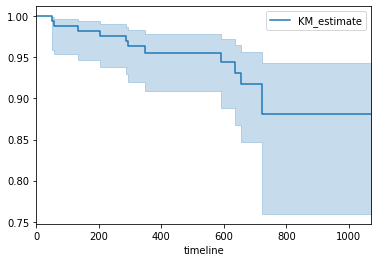

In [138]:
#groups = focus_group
kmf.plot()

In [139]:
from lifelines import CoxPHFitter

In [140]:
figo_map = {"FIGO grade 1": 1, "FIGO grade 2": 2, "FIGO grade 3" : 3}
focus_group['Histologic_Grade_FIGO'] = focus_group['Histologic_Grade_FIGO'].map(figo_map)

In [141]:
tumor_map = {"Stage I" : 1, "Stage II" : 2, "Stage III" : 3, "Stage IV" : 4}
focus_group['tumor_Stage-Pathological'] = focus_group['tumor_Stage-Pathological'].map(tumor_map)

In [143]:
cph = CoxPHFitter()
cph.fit(focus_group, duration_col = "Timeframe", event_col = "Negative_Outcome")

<lifelines.CoxPHFitter: fitted with 172 total observations, 161 right-censored observations>

In [144]:
cph.print_summary(model="untransformed variables", decimals=3)

<lifelines.CoxPHFitter: fitted with 172 total observations, 161 right-censored observations>
      duration col = 'Timeframe'
         event col = 'Negative_Outcome'
number of observations = 172.0
number of events observed = 11.0
partial log-likelihood = -42.514
  time fit was run = 2019-12-07 00:33:52 UTC
             model = untransformed variables


---
                          coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
Histologic_Grade_FIGO    1.369     3.931     0.443           0.501           2.236               1.651               9.357
tumor_Stage-Pathological 0.776     2.173     0.296           0.196           1.356               1.217               3.880

                             z     p  -log2(p)
Histologic_Grade_FIGO    3.093 0.002     8.980
tumor_Stage-Pathological 2.624 0.009     6.845
---
Concordance = 0.813
Log-likelihood ratio test = 17.976 on 2 df, -log2(p)=12.967


In [145]:
from lifelines.statistics import proportional_hazard_test

results = proportional_hazard_test(cph, focus_group, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
                          test_statistic     p  -log2(p)
Histologic_Grade_FIGO              0.230 0.632     0.663
tumor_Stage-Pathological           0.502 0.478     1.064


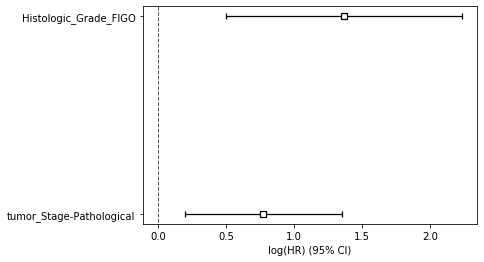

In [146]:
cph.plot()

In [148]:
wbf = lifelines.WeibullFitter().fit(time, status)

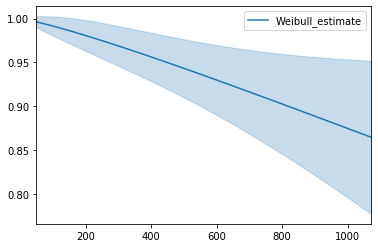

In [149]:
wbf.plot_survival_function()

## Step 3: Separate the data for pre-processing, and to prepare for Cox Proportional Hazard Test
Cox Proportional Hazard Test is a statistical test used to interpret the significance of Kaplan Meier plots, and potential connections between attributes and an event of interest (in this case, survival).

For the test to be performed properly, our data needs to be in a specific format. It requires data about Vital Status and time to event/last contact to be in a structured array, which we have titled 'survival_array' below.  

Additionally, the attributes we are interested in studying, which are the tumor stage and histologic grade, need to be separate from this array. We separated this data into a DataFrame we call 'tumor_stage_data' below.

Sometimes in the conversion, merging, and manipulation of DataFrames, columns' data types get mixed up.  Sci-kit learn requires columns of type "category" or "numeric" to perform pre-processing, which will create a binary DataFrame ready for performing Cox Proportional Hazard, as well as many other predictive analyses.  Oftentimes, these data types become an "object" type, so we will change them to type "category".

## Step 4: Perform Cox Proportional Hazard Test

In order to perform Cox Proportional Hazard Test, as well as many other Machine Learning and other statistical tests, our data needs to be pre-processed.  This is oftentimes done with Sci-kit Learn's encoder entitled "OneHotEncoder".  OneHotEncoder will create a new binary DataFrame of 0 and 1 for all the attributes in the DataFrame you give it, which will now be in the format for the test to be performed.

Here we will use our estimator of choice, Cox Proportional Hazard, to perform the test.

We can now look at our proportional hazard rations by viewing the following Series, based on the coefficients of the estimator, and the index of the pre-processed data.  These ratios help us know how influential a particular attribute is in relation to survival.  For instance, the ratio of 2.6235030 for Stage III tumors shows us that patients with a Stage III tumor had a 26.2% higher likelihood of death than if they did not have a Stage III tumor.

If you are interested in the accuracy of your model for predicting a positive or negative outcome based on your survival_array, you can view the estimator's "score" method.  This score is particularly relevant when testing your model against new data, but is still helpful in understanding its standalone accuracy as well.

Those are the basics of Survival Analysis on the cancer data we have provided in the cptac package.  This is by no means the only way this could have been done.  There are many other questions we could ask ourselves, and continue to study once we get to this point: 

How well does our model hold up for new data? What other attributes may be important for survival? What if I want to study the connection between clinical attributes and the likelihood of developing a second tumor during treatment?

With the functionality and flexibility of cptac, Sci-kit Survival and Sci-kit Learn, these answers can be explored, and a variety of other research projects could be done.  This use case is intended to be a springboard to help researchers get started in survival analysis, and leverage the cancer data we have to find important connections between clinical or molecular attributes and clinical outcomes.